In [1]:
import numpy as np
import pandas as pd
from time import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, log_loss, brier_score_loss
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')
%matplotlib inline
plt.style.use('ggplot')

from features.data_provider import get_train_and_test_dataset, get_feature_columns, get_whole_dataset
from models.helpers import get_feature_importance
from simulation.predictor import OneVsRestPredictor
from notebook_helpers import get_tournament_simulation_results, plot_bank_and_bets

In [2]:
def plot_reliability_diagram(probas, y):
    data_matrix = np.hstack((probas, y.reshape(y.shape[0], 1)))

    true_positive_rates = []
    x = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
    for ub in x:
        true_positives = 0
        all_outcomes = 0
        lb = (ub-0.1)
        for idx, (q, p, outcome) in enumerate(data_matrix):
            if p > lb and p <= ub:
                true_positives += outcome
                all_outcomes += 1
        if all_outcomes == 0:
            true_positive_rates.append(0.0)
        else:
            true_positive_rates.append(true_positives / all_outcomes)
            
    print("Brier Score", brier_score_loss(y, data_matrix[:, 0]))
    print("Log loss", log_loss(y, data_matrix[:, 0:2]))
            
    diagonal_line = np.linspace(0, 1, 100)
    plt.plot(diagonal_line,diagonal_line)
    plt.scatter(x, true_positive_rates)

In [3]:
param_grid = {'max_depth': [3, 5, 8, 12, None], 
              'min_samples_leaf': [1, 3, 5, 10, 15],
              'max_features': ["sqrt", "log2"]}
params = {"oob_score":True, "bootstrap":True, "n_jobs":-1, "n_estimators": 1000} 

# Home win vs rest

In [4]:
X, y = get_whole_dataset("home_win")
y.loc[y != 1] = 0

In [ ]:
rfc = RandomForestClassifier(**params)
clf = GridSearchCV(rfc, param_grid, cv=10)
clf.fit(X, y)
print(clf.best_params_)

In [ ]:
optimal_params = {**clf.best_params_, **params}
optimal_params

Brier Score 0.488589124562
Log loss 0.449501151696


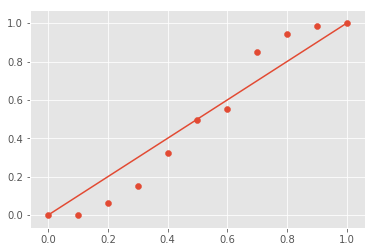

In [5]:
optimal_params = {'max_depth': 8,
 'max_features': 'sqrt',
 'min_samples_leaf': 10,
 'oob_score': True,
 'bootstrap': True,
 'n_jobs': -1,
 'n_estimators': 5000}

rfc_home = RandomForestClassifier(**optimal_params)
rfc_home.fit(X, y)
probas = rfc_home.predict_proba(X)
plot_reliability_diagram(probas, y.as_matrix())

Brier Score 0.490708734386
Log loss 0.453235300252


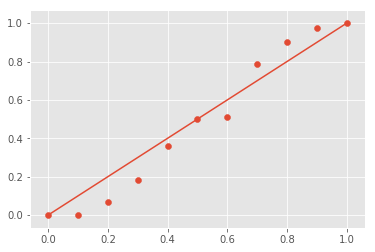

In [6]:
rfr_sigmoid_home = CalibratedClassifierCV(rfc_home, cv=10, method='sigmoid')
rfr_sigmoid_home.fit(X, y)
probas = rfr_sigmoid_home.predict_proba(X)
plot_reliability_diagram(probas, y.as_matrix())

Brier Score 0.507322926255
Log loss 0.441827066155


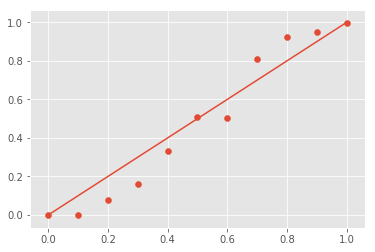

In [7]:
rfr_isotonic_home = CalibratedClassifierCV(rfc_home, cv=10, method='isotonic')
rfr_isotonic_home.fit(X, y)
probas = rfr_isotonic_home.predict_proba(X)
plot_reliability_diagram(probas, y.as_matrix())

# Draw vs rest

In [8]:
X, y = get_whole_dataset("home_win")
y.loc[y != 0] = -100
y.loc[y == 0] = 1
y.loc[y == -100] = 0

In [ ]:
y.loc[y == 1].shape
draw_idx = y.loc[y == 1].values
index_to_keep = np.array(np.random.choice(y.loc[y == 0].index.values, y.loc[y == 1].shape[0]), draw_idx)
y = y.loc[index_to_keep]

In [ ]:
rfc = RandomForestClassifier(**params)
clf = GridSearchCV(rfc, param_grid, cv=5)
clf.fit(X, y)
print(clf.best_params_)

In [ ]:
optimal_params = {**clf.best_params_, **params}
optimal_params

Brier Score 0.470478788332
Log loss 0.525441942441


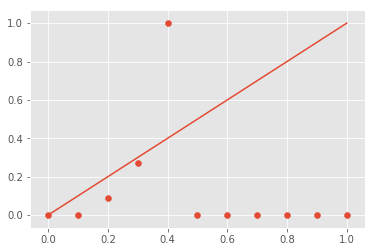

In [9]:
optimal_params = {'max_depth': 3,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'oob_score': True,
 'bootstrap': True,
 'n_jobs': -1,
 'n_estimators': 5000}

rfc_draw = RandomForestClassifier(**optimal_params)
rfc_draw.fit(X, y)
probas = rfc_draw.predict_proba(X)
plot_reliability_diagram(probas, y.as_matrix())

Brier Score 0.474632720869
Log loss 0.520544171015


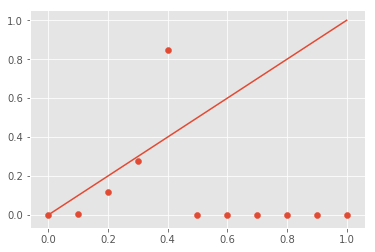

In [10]:
rfr_sigmoid_draw = CalibratedClassifierCV(rfc_draw, cv=10, method='sigmoid')
rfr_sigmoid_draw.fit(X, y)
probas = rfr_sigmoid_draw.predict_proba(X)
plot_reliability_diagram(probas, y.as_matrix())

Brier Score 0.482125435476
Log loss 0.510381042947


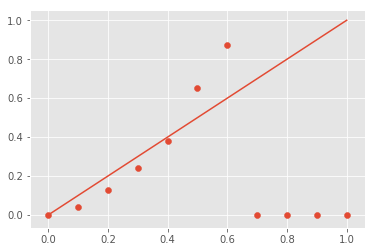

In [11]:
rfr_isotonic_draw = CalibratedClassifierCV(rfc_draw, cv=10, method='isotonic')
rfr_isotonic_draw.fit(X, y)
probas = rfr_isotonic_draw.predict_proba(X)
plot_reliability_diagram(probas, y.as_matrix())

# Away win vs rest

In [12]:
X, y = get_whole_dataset("home_win")
y.loc[y != -1] = 0
y.loc[y == -1] = 1

In [ ]:
rfc = RandomForestClassifier(**params)
clf = GridSearchCV(rfc, param_grid, cv=5)
clf.fit(X, y)
print(clf.best_params_)

In [ ]:
optimal_params = {**clf.best_params_, **params}
optimal_params

Brier Score 0.445046536336
Log loss 0.518493167375


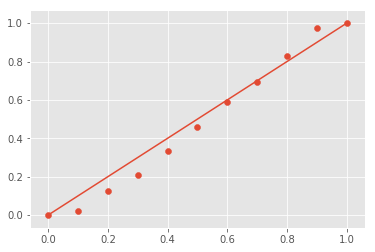

In [13]:
optimal_params = {'max_depth': 5,
 'max_features': 'sqrt',
 'min_samples_leaf': 15,
 'oob_score': True,
 'bootstrap': True,
 'n_jobs': -1,
 'n_estimators': 5000}

rfc_away = RandomForestClassifier(**optimal_params)
rfc_away.fit(X, y)
probas = rfc_away.predict_proba(X)
plot_reliability_diagram(probas, y.as_matrix())

Brier Score 0.456673221387
Log loss 0.518735405867


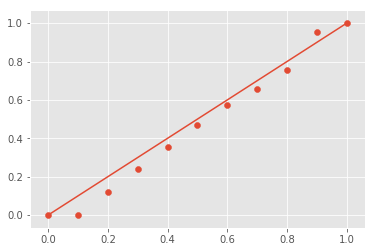

In [14]:
rfr_sigmoid_away = CalibratedClassifierCV(rfc_away, cv=10, method='sigmoid')
rfr_sigmoid_away.fit(X, y)
probas = rfr_sigmoid_away.predict_proba(X)
plot_reliability_diagram(probas, y.as_matrix())

Brier Score 0.46947051252
Log loss 0.50977261779


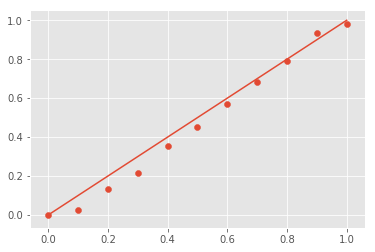

In [15]:
rfr_isotonic_away = CalibratedClassifierCV(rfc_away, cv=10, method='isotonic')
rfr_isotonic_away.fit(X, y)
probas = rfr_isotonic_away.predict_proba(X)
plot_reliability_diagram(probas, y.as_matrix())

# Predict World Cup 2018

In [16]:
def plot(data):
    tournament_simulation = data["simulation"]
    print(f"Accuracy:", sum(tournament_simulation["outcome"] == tournament_simulation["true_outcome"]) / tournament_simulation.shape[0])
    plot_bank_and_bets(data["unit"])
    plot_bank_and_bets(data["kelly"])

In [17]:
tournament_template_file = 'data/original/wc_2018_games_real.csv'
match_bet_file = 'data/original/wc_2018_bets.csv'
tournament_template = pd.read_csv(tournament_template_file)
match_bets = pd.read_csv(match_bet_file)
predictor = OneVsRestPredictor(rfr_isotonic_home, rfr_isotonic_draw, rfr_isotonic_away)
wc2018 = get_tournament_simulation_results(tournament_template, predictor, match_bets[["1", "X", "2"]].values)

tmp = {}
tmp["simulation"] = wc2018[0]
tmp["unit"] = wc2018[1]
tmp["kelly"] = wc2018[2]

plot(tmp)

KeyboardInterrupt: 